# Модель предсказания вероятности покупки для интернет-магазина

## Описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

## Цель

Предсказать вероятность покупки в течение 90 дней

## Задачи

-	Изучить данные
-	Разработать полезные признаки
-	Создать модель для классификации пользователей
-	Улучшить модель и максимизировать метрику roc_auc
-	Выполнить тестирование

## Данные

### apparel-purchases
история покупок

1.	`client_id`      - идентификатор пользователя
2.	`quantity`       - количество товаров в заказе
3.	`price`          - цена товара
4.	`category_ids`   - вложенные категории, к которым отнсится товар
5.	`date`           - дата покупки
6.	`message_id`     - идентификатор сообщения из рассылки

### apparel-messages
история рекламных рассылок

1.	`bulk_campaign_id` -  идентификатор рекламной кампании
2.	`client_id` -  идентификатор пользователя
3.	`message_id` -  идентификатор сообщений
4.	`event` -  тип действия
5.	`channel` - канал рассылки
6.	`date` - дата рассылки
7.	`created_at` - точное время создания сообщения

### apparel-target_binary
совершит ли клиент покупку в течение следующих 90 дней

- `client_id` идентификатор пользователя
- `target` целевой признак

### full_campaign_daily_event
Агрегация общей базы рассылок по дням и типам событий

1.	`date` - дата
2.	`bulk_campaign_id` -  идентификатор рассылки
3.	`count_event`* - общее количество каждого события event
4.	`nunique_event`* - количество уникальных client_id в каждом событии

### full_campaign_daily_event_channel
Агрегация по дням с учетом событий и каналов рассылки

1. `date` -  дата
2. `bulk_campaign_id` -  дентификатор рассылки
3. `count_event_channel`* - общее количество каждого события по каналам
4. `nunique_event_channel`* -  количество уникальных client_id по событиям и каналам

## Подготовка данных

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import phik
from phik.report import plot_correlation_matrix
import shap
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier


RANDOM_STATE = 123

зададим путь

In [301]:
project_path_01 = "C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Workshop\\WS_02\\filtered_data\\"
project_path_02 = "/datasets/"

In [ ]:
if os.path.exists(project_path_01):
    purchases_df = pd.read_csv(project_path_01 + 'apparel-purchases.csv')
    messages_df = pd.read_csv(project_path_01 + 'apparel-messages.csv')
    target_df = pd.read_csv(project_path_01 + 'apparel-target_binary.csv')
    event_df = pd.read_csv(project_path_01 + 'full_campaign_daily_event.csv')
    channel_df = pd.read_csv(project_path_01 + 'full_campaign_daily_event_channel.csv')
else:
    print("Smth wrong")

Посмотрим на данные

In [303]:
def df_info (df):
        print(df.info())
        return df.head()

In [304]:
df_info(purchases_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
None


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [305]:
df_info(messages_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [306]:
df_info(target_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [307]:
df_info(event_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [308]:
df_info(channel_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Переименуем дату в датафреймах покупок и рассылок и переведем в формат даты

In [309]:
purchases_df = purchases_df.rename(columns={'date': 'purchase_date'})
messages_df = messages_df.rename(columns={'date': 'message_date'})

In [310]:
purchases_df['purchase_date'] = pd.to_datetime(purchases_df['purchase_date'])
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'])

In [311]:
purchases_df.info(), messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      202208 non-null  int64         
 1   quantity       202208 non-null  int64         
 2   price          202208 non-null  float64       
 3   category_ids   202208 non-null  object        
 4   purchase_date  202208 non-null  datetime64[ns]
 5   message_id     202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   message_

(None, None)

проверим полные дубли

In [312]:
purchases_df.duplicated().sum(), purchases_df.shape

(73020, (202208, 6))

In [313]:
purchases_df.drop_duplicates(inplace=True)
purchases_df.shape

(129188, 6)

In [314]:
messages_df.duplicated().sum(), messages_df.shape

(48610, (12739798, 7))

In [315]:
messages_df.drop_duplicates(inplace=True)
messages_df.shape

(12691188, 7)

In [316]:
target_df.duplicated().sum(), event_df.duplicated().sum(), channel_df.duplicated().sum()

(0, 0, 0)

Проверим признак 'category_ids'  на пустые списки

In [321]:
mask = purchases_df.loc[purchases_df.loc[:,'category_ids'] == "[]", 'category_ids']
mask.shape

(2738,)

Заполним самым частым значением

In [322]:
purchases_df.loc[purchases_df.loc[:,'category_ids'] == "[]", 'category_ids'] = np.nan

In [323]:
purchases_df['category_ids'].fillna(purchases_df['category_ids'].mode()[0], inplace=True)

In [324]:
purchases_df.isna().sum()

client_id        0
quantity         0
price            0
category_ids     0
purchase_date    0
message_id       0
dtype: int64

Выделим верховую категорию в отдельный признак

In [325]:
# переведем объект в список
purchases_df['category_ids'] = purchases_df['category_ids'].apply(lambda x: ast.literal_eval(x))

In [326]:
purchases_df['main_category'] = purchases_df['category_ids'].apply(lambda x: x[0])

Присоеденим рекламный датафрейм по ключу client_id и message_id

In [327]:
df = pd.merge(messages_df, purchases_df, how ='left', on=['client_id', 'message_id'])
df.shape

(12973616, 12)

In [328]:
df.isna().sum()

bulk_campaign_id           0
client_id                  0
message_id                 0
event                      0
channel                    0
message_date               0
created_at                 0
quantity            12471491
price               12471491
category_ids        12471491
purchase_date       12471491
main_category       12473814
dtype: int64

Удалим столбец category_ids

In [331]:
df.drop(columns="category_ids", inplace=True)

In [332]:
df.columns

Index(['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel',
       'message_date', 'created_at', 'quantity', 'price', 'purchase_date',
       'main_category'],
      dtype='object')

In [333]:
df.drop(columns=['bulk_campaign_id', 'purchase_date', 'message_id',
       'bulk_campaign_id', 'message_date', 'created_at'], inplace=True)

In [336]:
df.isna().sum()

client_id               0
event                   0
channel                 0
quantity         12471491
price            12471491
main_category    12473814
dtype: int64

In [337]:
df.quantity.fillna(0, inplace=True)
df.price.fillna(0, inplace=True)
df.main_category.fillna("NC", inplace=True)

In [338]:
df.isna().sum()

client_id        0
event            0
channel          0
quantity         0
price            0
main_category    0
dtype: int64

In [341]:
df.main_category.unique(), 

(array(['NC', '4', '2', '5562', '1', '6060', '5963', '3', '5'],
       dtype=object),)

In [339]:
df.event.unique(), 

(array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
        'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
       dtype=object),)

In [ ]:
# final_df = df.groupby('client_id').agg(
#     quantity=('quantity', 'sum'),
#     price=('price', 'sum'),
#     click_count=('event', lambda x: (x == 'click').sum()),  
#     open_count=('event', lambda x: (x == 'open').sum()),
#     close_count=('event', lambda x: (x == 'close').sum()),
#     purchase_count=('event', lambda x: (x == 'purchase').sum()),
#     send_count=('event', lambda x: (x == 'send').sum()),
#     complain_count=('event', lambda x: (x == 'complain').sum()),  
#     unsubscribe_count=('event', lambda x: (x == 'unsubscribe').sum()),
#     subscribe_count=('event', lambda x: (x == 'subscribe').sum()),
#     hard_bounce_count=('event', lambda x: (x == 'hard_bounce').sum()),
#     soft_bounce_count=('event', lambda x: (x == 'soft_bounce').sum()),
#     hbq_spam_count=('event', lambda x: (x == 'hbq_spam').sum()),
#     NC_cat=('main_category', lambda x: (x == 'NC').sum()),  
#     cat_4=('main_category', lambda x: (x == '4').sum()), 
#     cat_2=('main_category', lambda x: (x == '2').sum()),  
#     cat_5562_count=('main_category', lambda x: (x == '5562').sum()),
#     cat_1=('main_category', lambda x: (x == '1').sum()), 
#     cat_6060=('main_category', lambda x: (x == '6060').sum()),  
#     cat_5963=('main_category', lambda x: (x == '5963').sum()),
#     cat_3=('main_category', lambda x: (x == '3').sum()),  
#     cat_5=('main_category', lambda x: (x == '5').sum()),
#     email=('channel', lambda x: (x == 'email').sum()),
#     mobile_push=('channel', lambda x: (x == 'mobile_push').sum()),  
# ).reset_index()

In [ ]:
#final_df.to_csv(path_or_buf=project_path_01+'/final_df.csv', index=None)

In [346]:
df = pd.read_csv(project_path_01 + 'final_df.csv')

In [347]:
df.head()

,client_id,quantity,price,click_count,open_count,close_count,purchase_count,send_count,complain_count,unsubscribe_count,...,cat_4,cat_2,cat_5562_count,cat_1,cat_6060,cat_5963,cat_3,cat_5,email,mobile_push
0,1515915625468060902,55.0,52745.0,26,39,0,25,130,0,1,...,55,0,0,0,0,0,0,0,221,0
1,1515915625468061003,24.0,56540.0,10,10,0,6,159,0,0,...,24,0,0,0,0,0,0,0,185,0
2,1515915625468061099,0.0,0.0,8,51,0,0,215,0,0,...,0,0,0,0,0,0,0,0,182,94
3,1515915625468061100,4.0,4196.0,1,157,0,1,267,0,0,...,4,0,0,0,0,0,0,0,0,428
4,1515915625468061170,37.0,63527.0,23,37,0,8,248,0,0,...,30,7,0,0,0,0,0,0,225,91


In [349]:
df.client_id.nunique()

53329

Соеденим с целевым датафреймом

In [351]:
df = pd.merge(target_df, df, how ='left', on=['client_id'])
df.shape

(49849, 26)

## EDA

In [352]:
def eda_graph (data, column, bins):
    plt.figure(figsize=(15,10))
    sns.histplot(x=column, data=data, bins=bins)
    plt.title('Гистограмма признака ' + column)
    plt.ylabel('Количество значений')
    plt.xlabel(column)
    plt.show()

### quantity

In [353]:
df.quantity.value_counts()

quantity
4.0       6390
0.0       4437
3.0       4239
6.0       3139
5.0       3028
          ... 
220.0        1
506.0        1
2849.0       1
187.0        1
258.0        1
Name: count, Length: 226, dtype: int64

### price

In [354]:
df.price.describe()

count    4.198200e+04
mean     1.540139e+04
std      3.353824e+04
min      0.000000e+00
25%      3.592000e+03
50%      8.394000e+03
75%      1.749500e+04
max      3.130890e+06
Name: price, dtype: float64

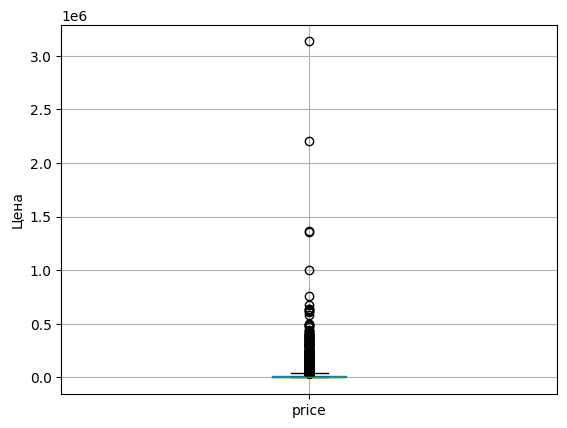

In [357]:
df.boxplot(column='price', return_type='both')
plt.ylabel('Цена')
plt.show()

In [359]:
mask = df.loc[df.loc[:,'price'] > 1000000]
mask
len(mask), df.shape

(5, (49849, 26))

In [ ]:
# df.drop(mask.index, inplace=True)
# df.shape

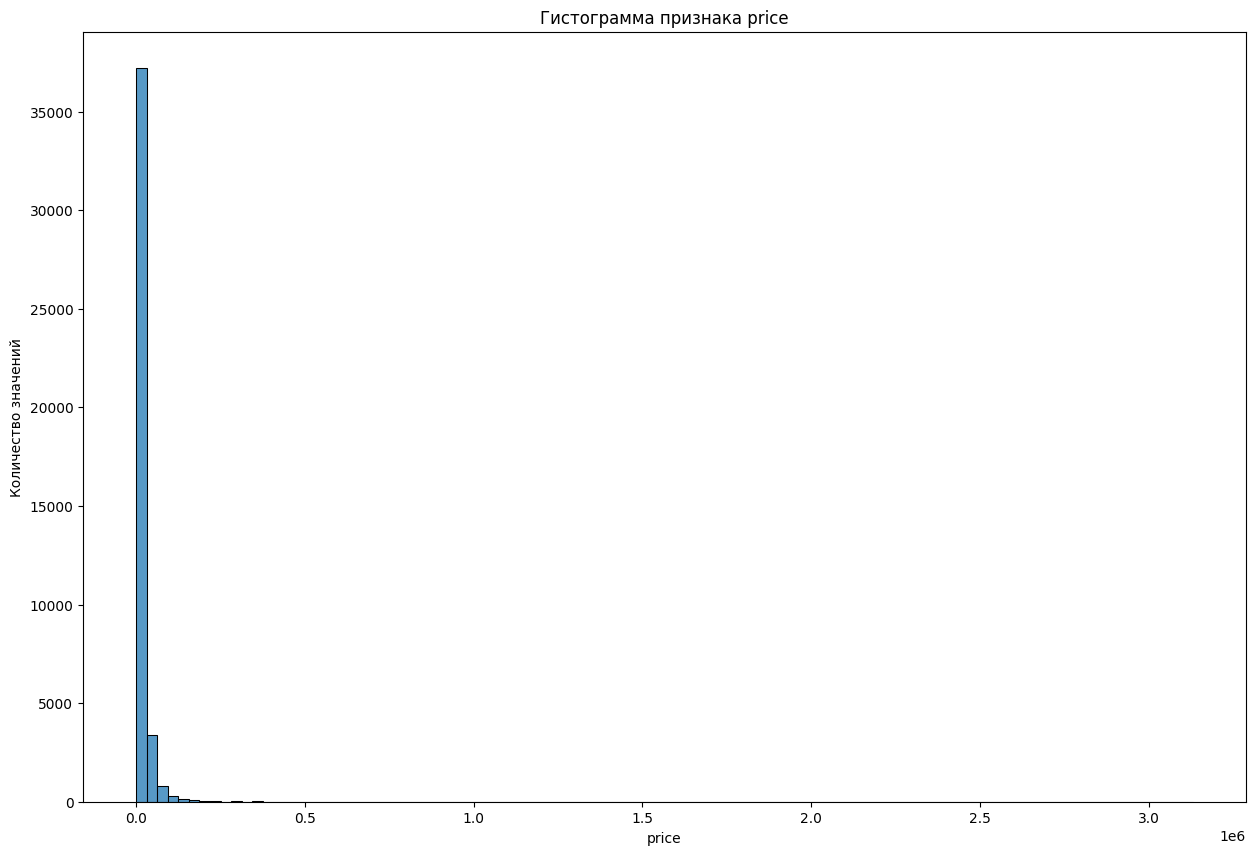

In [360]:
eda_graph(df, 'price', 100)

## target

In [361]:
df['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

опять дисбаланс классов(

## Корреляционный анализ

In [362]:
corr_matrix_spear = pd.DataFrame(df.corr(method='spearman'))
corr_matrix_spear

,client_id,target,quantity,price,click_count,open_count,close_count,purchase_count,send_count,complain_count,...,cat_4,cat_2,cat_5562_count,cat_1,cat_6060,cat_5963,cat_3,cat_5,email,mobile_push
client_id,1.000000,-0.006466,-0.113976,-0.107046,-0.139177,-0.193922,0.003654,-0.059109,-0.225854,-0.025216,...,-0.114688,-0.017024,0.012295,0.003629,0.044781,0.029909,0.011233,-0.001022,-0.414756,0.069122
target,-0.006466,1.000000,0.042099,0.009699,0.072940,0.049330,-0.000700,0.045101,0.031609,0.001735,...,0.027952,-0.001699,0.019166,-0.001212,0.024327,0.010532,-0.001565,-0.000700,-0.000791,0.050871
quantity,-0.113976,0.042099,1.000000,0.731158,0.576324,0.243940,-0.007588,0.912741,0.134125,0.003961,...,0.595203,0.208572,0.256425,0.011211,0.118509,0.045541,0.015975,0.008355,0.332083,-0.001843
price,-0.107046,0.009699,0.731158,1.000000,0.460899,0.191212,-0.007565,0.662150,0.094589,0.006290,...,0.518069,0.250509,0.077820,0.011554,-0.022110,0.034005,0.011031,0.007976,0.316952,-0.048647
click_count,-0.139177,0.072940,0.576324,0.460899,1.000000,0.287565,0.005368,0.505382,0.244518,-0.006803,...,0.384005,0.145696,0.133198,0.004420,0.070018,0.037578,0.007826,0.008380,0.469354,0.031004
open_count,-0.193922,0.049330,0.243940,0.191212,0.287565,1.000000,0.008038,0.106517,0.408479,0.006556,...,0.162305,0.084943,-0.011423,0.004055,-0.012325,-0.000816,0.005685,0.007031,0.501144,0.361541
close_count,0.003654,-0.000700,-0.007588,-0.007565,0.005368,0.008038,1.000000,-0.007824,0.005577,-0.000384,...,-0.005348,-0.002271,-0.002565,-0.000041,-0.000848,-0.000476,-0.000053,-0.000024,-0.004336,0.008411
purchase_count,-0.059109,0.045101,0.912741,0.662150,0.505382,0.106517,-0.007824,1.000000,0.162416,-0.001850,...,0.544249,0.183762,0.292500,0.009698,0.132078,0.051878,0.016245,0.008173,0.197932,0.076057
send_count,-0.225854,0.031609,0.134125,0.094589,0.244518,0.408479,0.005577,0.162416,1.000000,-0.029588,...,0.072646,-0.028290,0.166193,0.003168,0.011529,0.001519,0.009010,0.005810,0.336246,0.739600
complain_count,-0.025216,0.001735,0.003961,0.006290,-0.006803,0.006556,-0.000384,-0.001850,-0.029588,1.000000,...,-0.001045,0.005334,-0.003272,-0.000665,-0.002677,-0.004489,-0.000858,-0.000384,-0.026899,-0.005015


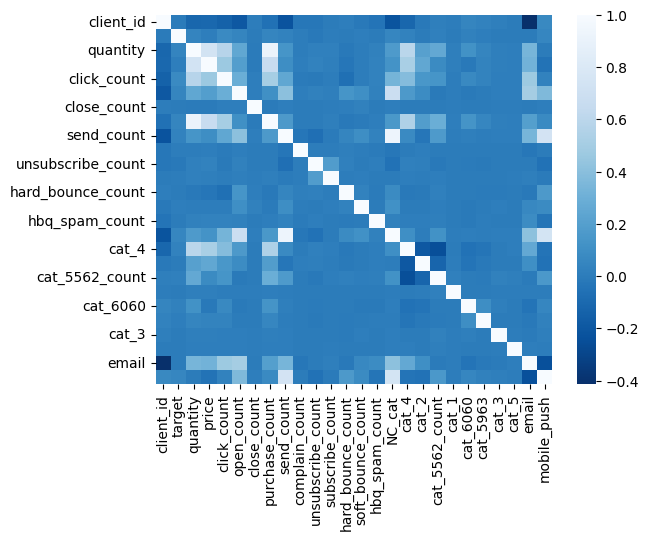

In [364]:
sns.heatmap(df.corr(method='spearman'), cmap='Blues_r')
plt.show()

In [365]:
corr_matrix_phik = df.phik_matrix(
    interval_cols=df.select_dtypes(include='float').columns.to_list())

C:\Users\kushn\AppData\Roaming\Python\Python312\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable client_id is large: 49849. Are you sure this is not an interval variable? Analysis for pairs of variables including client_id can be slow.
  warnings.warn(


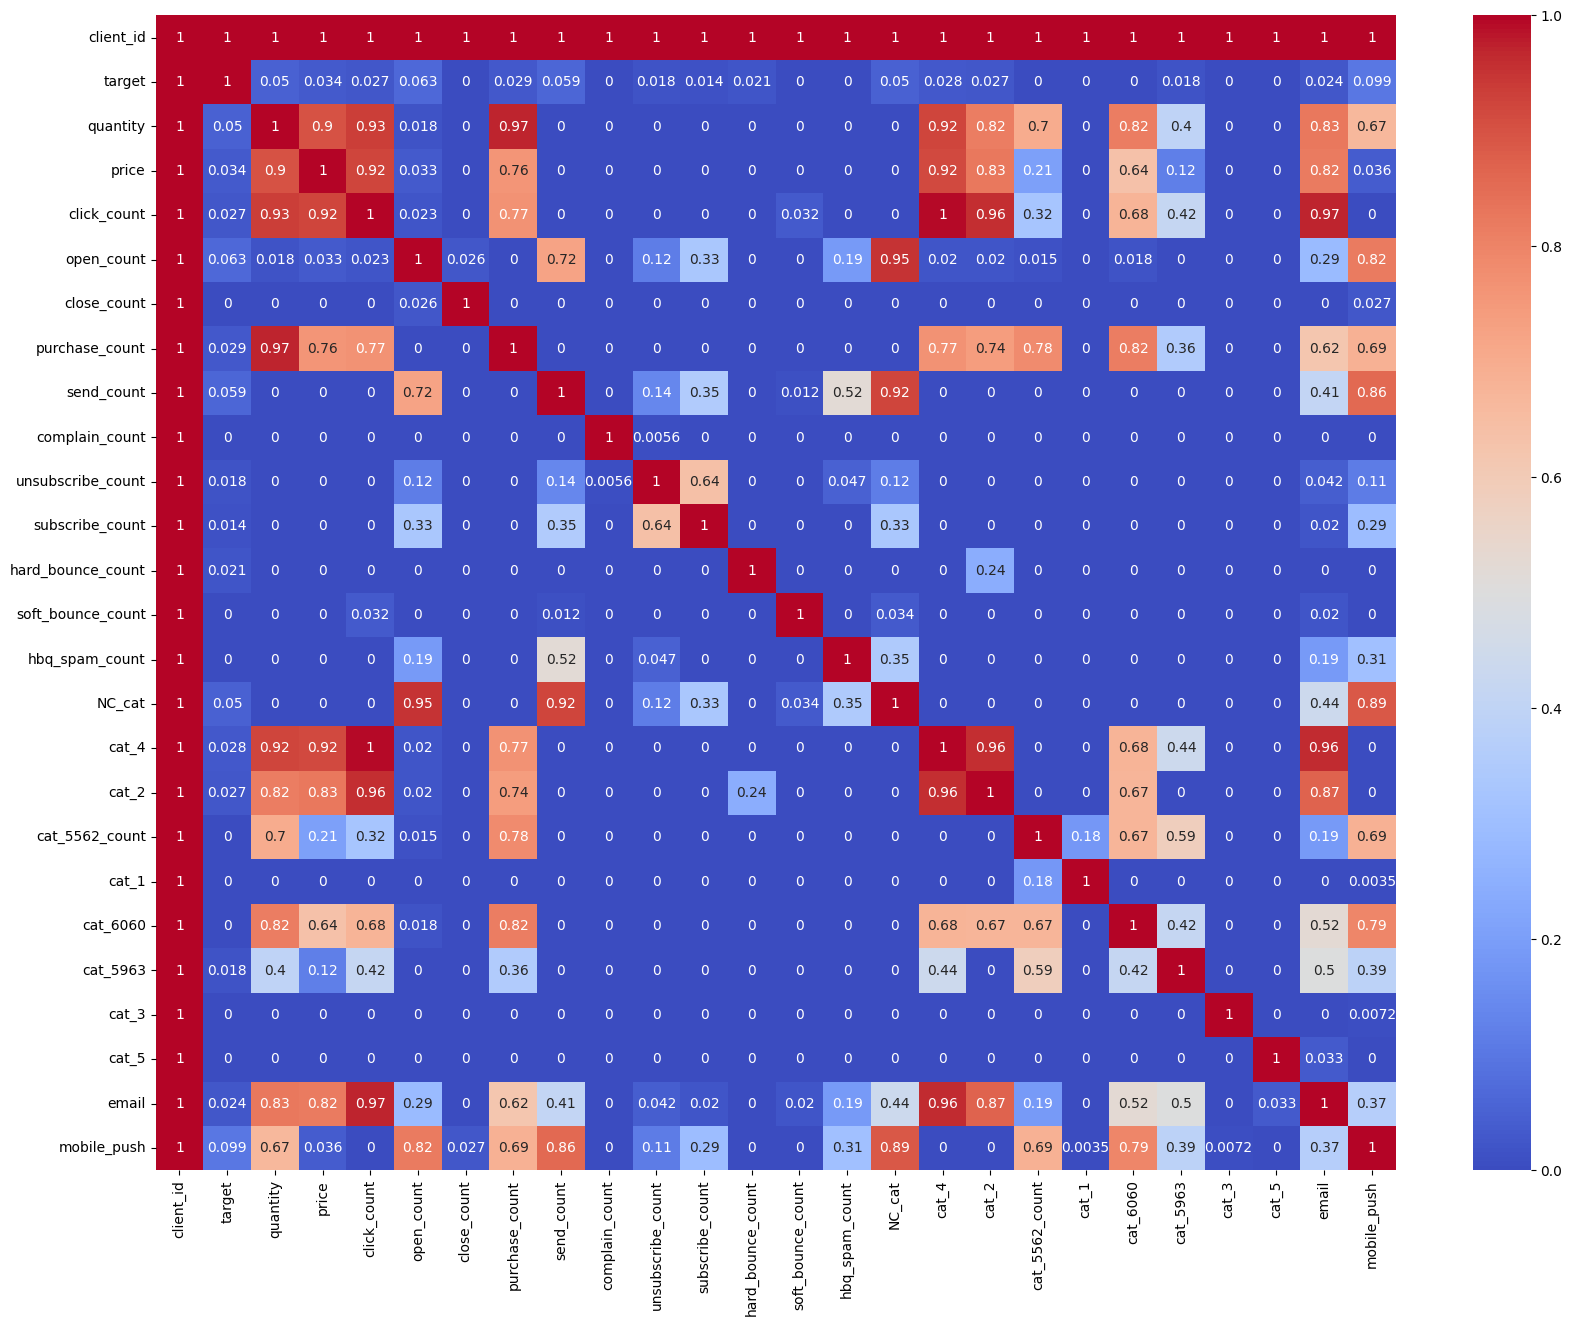

In [366]:
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix_phik, annot=True, cmap='coolwarm')
plt.show()

Н-да... с таргетом ничего не коррелирует...

## Пайплайн

In [367]:
X = df.drop(['target'], axis=1)
y = df['target']

In [368]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [369]:
X_train.shape, X_valid.shape

((39879, 25), (9970, 25))

In [370]:
y_train.shape, y_valid.shape

((39879,), (9970,))

In [371]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), X_train.columns.to_list())
    ]
)

In [372]:
pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
param_grid = [
        {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
        },
        {
        'models': [LinearSVC(
            random_state=RANDOM_STATE
        )],
        'models__C': [0.1, 1, 10],
        'models__penalty': ['l1', 'l2'],
        'models__loss': ['hinge', 'squared_hinge'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
        },
        {
        'models': [DecisionTreeClassifier(
            max_depth=None,
            random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 20),
        'models__criterion': ['gini', 'entropy'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],

        },
        {'models': [KNeighborsClassifier()],
            'models__n_neighbors': range(2, 10),
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        },
    #   {
    #     'models': [SVC(probability=False,
    #         random_state=RANDOM_STATE,
    #     )],
    #     'models__probability': [True], 
    #     'models__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    #     'models__degree': range(1, 3),
    #     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    #   }
]       
 

In [379]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter = 50,
    n_jobs=-1
)

In [380]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['client_id',
                                                                                'quantity',
                                                                                'price',
                                                                                'click_count',
                                                                                'open_count',
                                                                                'close_count',
                                                                                'purchase_count',
                                                                                'send_count',
                                                                                'complain_count',
                                                                                'unsubscribe_count',
                                                                                'subscribe_count',
                                                                                'hard_bounce_count',
                                                                                'soft_bounce_count',
                                                                                'hbq_spam_count',
                                                                                'NC_cat',
                                                                                'cat...
                                         'models__max_depth': range(2, 10),
                                         'models__min_samples_leaf': range(1, 20),
                                         'models__min_samples_split': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=123, scoring='roc_auc')

In [387]:
print(f'ROC_AUC_train:\
      {randomized_search.best_score_:.2f}')

ROC_AUC_train:      0.64


In [386]:
roc_auc_test = roc_auc_score(y_valid,
                             randomized_search.predict_proba(X_valid)[:,1])
print(f'ROC_AUC_test: {roc_auc_test:.3f}')

ROC_AUC_test: 0.631


In [389]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train, y_train)

roc_auc_score(y_valid,
               dummy_clf.predict_proba(X_valid)[:,1])

0.5